In [1]:
import os
import configparser
import numpy as np
import logging
import sys
import random
import pandas as pd

In [2]:
import hana_ml
print (hana_ml.__version__)

2.10.21091803


In [3]:
from hdbcli import dbapi
dbapi.__name__
#print(dbapi._version_)
from hana_ml import dataframe
from hana_ml.algorithms.pal import trees
from hana_ml.dataframe import ConnectionContext
from hana_ml import algorithms
##from hana_ml.algorithms.pal import classification
from hana_ml.algorithms.pal import clustering
from hana_ml.algorithms.pal import trees

In [4]:
url = 'f285a971-188b-4201-ac31-6e9b8680fcd4.hana.d022166-haas-hc-dev.dev-aws.hanacloud.ondemand.com'
user = 'PAL'
passwd = 'Abcd123!'
port = 443

In [5]:
conn = dataframe.ConnectionContext("{}".format(url),int("{}".format(port)), "{}".format(user), "{}".format(passwd),
                            encrypt="true", sslValidateCertificate="false")

In [6]:
conn.sql_tracer.enable_sql_trace(True)

In [7]:
conn.sql_tracer.enable_trace_history(True)

In [8]:
ts_hdf =  conn.table('PAL_ARIMA_DATA_TBL', schema='PAL')

In [9]:
ts_hdf.dtypes()

[('TIMESTAMP', 'INT', 10, 10, 10, 0), ('Y', 'DOUBLE', 15, 15, 15, 0)]

In [16]:
ts_hdf.count()

264

In [10]:
ts_hdf.head(5).collect()

,TIMESTAMP,Y
0,1,-24.525
1,2,34.720
2,3,57.325
3,4,10.340
4,5,-12.890


In [22]:
df_train = conn.sql('SELECT * from PAL_ARIMA_DATA_TBL where TIMESTAMP < 255')

In [18]:
df_test = conn.sql('SELECT * from PAL_ARIMA_DATA_TBL where TIMESTAMP >= 255')

In [19]:
from hana_ml.algorithms.pal.tsa.auto_arima import AutoARIMA

In [20]:
autoarima = AutoARIMA(search_strategy='stepwise', allow_linear=True, thread_ratio=1.0)

In [23]:
autoarima.fit(data=df_train)

INFO:hana_ml.ml_base:Executing SQL: DO
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'SEARCH_STRATEGY';
int_value[1] := 1;
double_value[1] := NULL;
string_value[1] := NULL;
param_name[2] := N'MAX_ORDER';
int_value[2] := 1;
double_value[2] := NULL;
string_value[2] := NULL;
param_name[3] := N'ALLOW_LINEAR';
int_value[3] := 1;
double_value[3] := NULL;
string_value[3] := NULL;
param_name[4] := N'OUTPUT_FITTED';
int_value[4] := 1;
double_value[4] := NULL;
string_value[4] := NULL;
param_name[5] := N'THREAD_RATIO';
int_value[5] := NULL;
double_value[5] := 1.0;
string_value[5] := NULL;
param_name[6] := N'DEPENDENT_VARIABLE';
int_value[6] := NULL;
double_value[6] := NULL;
string_value[6] := N'Y';
params = UNNEST(:param_name, :int_value, :double_value, :string_value);
in_0 = SELECT "TIMESTAMP", "Y" FROM (SELECT * from PAL_ARIMA_DATA_TBL where TIMESTAMP < 255) AS "DT_13"

In [24]:
autoarima.model_.collect().head(4)

,KEY,VALUE
0,p,3
1,AR,-0.608429;0.110097;0.216045
2,d,0
3,q,1


In [25]:
autoarima.fitted_.collect().set_index('TIMESTAMP').head(6)

,FITTED,RESIDUALS
TIMESTAMP,,
1,18.739105,-43.264105
2,-4.378036,39.098036
3,42.517394,14.807606
4,-1.348957,11.688957
5,-20.554452,7.664452
6,34.860768,4.184232


In [27]:
df_predicted = autoarima.predict(forecast_length=10)

INFO:hana_ml.ml_base:Executing SQL: CREATE LOCAL TEMPORARY  COLUMN TABLE #PAL_ARIMA_PREDICT_DATA_AA308A0C_5CBC_11EC_AFFB_ACDE48001122 ("TIMESTAMP" INTEGER, "Y" DOUBLE)
INFO:hana_ml.ml_base:Executing SQL: DO (IN in_0 TABLE ("TIMESTAMP" INT, "Y" DOUBLE) => "#PAL_ARIMA_PREDICT_DATA_AA308A0C_5CBC_11EC_AFFB_ACDE48001122",
    IN in_1 TABLE ("KEY" NVARCHAR(100), "VALUE" NVARCHAR(5000)) => "#PAL_AUTOARIMA_MODEL_TBL_1_E9B818C6_5CBB_11EC_AFFB_ACDE48001122")
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'FORECAST_LENGTH';
int_value[1] := 10;
double_value[1] := NULL;
string_value[1] := NULL;
params = UNNEST(:param_name, :int_value, :double_value, :string_value);
CALL _SYS_AFL.PAL_ARIMA_FORECAST(:in_0, :in_1, :params, out_0);
CREATE LOCAL TEMPORARY COLUMN TABLE "#PAL_ARIMA_FORECAST_RESULT_TBL_1_AA4CA584_5CBC_11EC_AFFB_ACDE48001122" AS (SELECT * FROM :out_0);
END



In [30]:
df_predicted.head(10).collect()

,TIMESTAMP,FORECAST,SE,LO80,HI80,LO95,HI95
0,0,55.550243,4.260469,50.090230,61.010256,47.199876,63.900610
1,1,4.398657,4.541924,-1.422055,10.219369,-4.503352,13.300665
2,2,-19.576049,4.568130,-25.430345,-13.721753,-28.529419,-10.622679
3,3,33.785752,4.775224,27.666054,39.905450,24.426485,43.145019
4,4,55.157727,6.022978,47.438967,62.876486,43.352907,66.962547
5,5,4.427083,6.331198,-3.686677,12.540843,-7.981838,16.836004
6,6,-19.356511,6.349566,-27.493810,-11.219211,-31.801432,-6.911590
7,7,33.672778,6.481580,25.366296,41.979260,20.969114,46.376442
8,8,54.887286,7.502141,45.272902,64.501669,40.183359,69.591212
9,9,4.525551,7.726573,-5.376454,14.427555,-10.618254,19.669355


In [31]:
import matplotlib.pyplot as plt

In [45]:
train = df_train.collect().to_numpy()
test = df_test.collect().to_numpy()
predicted = df_predicted.collect().to_numpy()

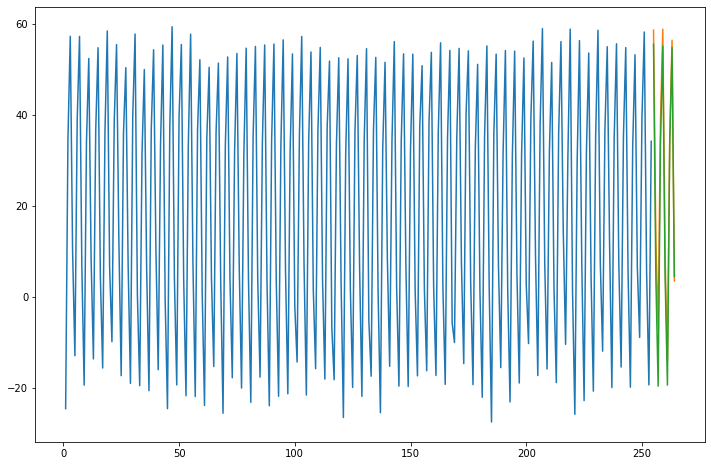

In [49]:
plt.subplots(figsize=(12,8))
plt.plot(train[:,0], train[:,1])
plt.plot(test[:,0], test[:,1])
plt.plot(predicted[:,0]+255,predicted[:,1])

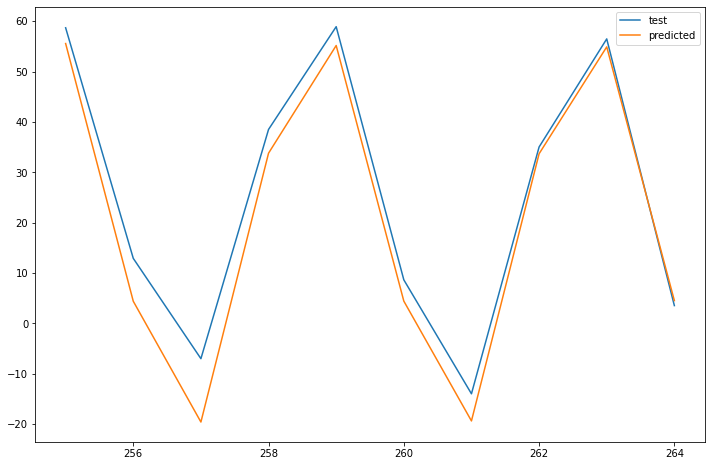

In [54]:
plt.subplots(figsize=(12,8))
plt.plot(test[:,0], test[:,1], label='test')
plt.plot(predicted[:,0]+255,predicted[:,1], label='predicted')
plt.legend(loc="upper right")

In [55]:
# create csv
df_train.collect().to_csv('train_autoarima.csv', index=False)

In [57]:
autoarima.get_store_procedure()

{'fit': '_SYS_AFL.PAL_AUTOARIMA(:in_0, :params, out_0, out_1);',
 'predict': '_SYS_AFL.PAL_ARIMA_FORECAST(:in_0, :in_1, :params, out_0);'}

In [58]:
df_test.collect().to_csv('test_autoarima.csv', index=False)

In [59]:
autoarima.get_predict_execute_statement()

'DO (IN in_0 TABLE ("TIMESTAMP" INT, "Y" DOUBLE) => "#PAL_ARIMA_PREDICT_DATA_AA308A0C_5CBC_11EC_AFFB_ACDE48001122",\n    IN in_1 TABLE ("KEY" NVARCHAR(100), "VALUE" NVARCHAR(5000)) => "#PAL_AUTOARIMA_MODEL_TBL_1_E9B818C6_5CBB_11EC_AFFB_ACDE48001122")\nBEGIN\nDECLARE param_name VARCHAR(5000) ARRAY;\nDECLARE int_value INTEGER ARRAY;\nDECLARE double_value DOUBLE ARRAY;\nDECLARE string_value VARCHAR(5000) ARRAY;\nparam_name[1] := N\'FORECAST_LENGTH\';\nint_value[1] := 10;\ndouble_value[1] := NULL;\nstring_value[1] := NULL;\nparams = UNNEST(:param_name, :int_value, :double_value, :string_value);\nCALL _SYS_AFL.PAL_ARIMA_FORECAST(:in_0, :in_1, :params, out_0);\nCREATE LOCAL TEMPORARY COLUMN TABLE "#PAL_ARIMA_FORECAST_RESULT_TBL_1_AA4CA584_5CBC_11EC_AFFB_ACDE48001122" AS (SELECT * FROM :out_0);\nEND\n'